In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn.preprocessing  import StandardScaler

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed=RANDOM_STATE)

EPOCHS = 20001 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

In [3]:
data_df = pd.read_csv('/content/fifa_2019.csv')
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [4]:
cols = data_df.columns

for col in cols:
  print(f'\n Column : {col} - {data_df[col].unique()}')


 Column : Unnamed: 0 - [    0     1     2 ... 18204 18205 18206]

 Column : ID - [158023  20801 190871 ... 241638 246268 246269]

 Column : Name - ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']

 Column : Age - [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]

 Column : Photo - ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']

 Column : Nationality - ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Swe

In [5]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [6]:
data_df = data_df[data_df['Position'].notnull()]
data_df.shape

(18147, 89)

In [7]:
rel_cols = ['Position','Finishing','HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
             'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
             'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
             'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
             'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
             'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
             'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [8]:
data_df.shape

(18147, 34)

In [9]:
data_df.isna().sum()

,0
Position,0
Finishing,0
HeadingAccuracy,0
ShortPassing,0
Volleys,0
Dribbling,0
Curve,0
FKAccuracy,0
LongPassing,0
BallControl,0


In [16]:
goalkeeper = 'GK'
forward = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW']
midfielders = ['CM', 'LCM',  'RCM', 'CDM', 'RDM' ,'LAM', 'CAM', 'RAM', 'LM', 'RM', 'LDM' ]
defenders = [ 'LWB', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

In [17]:
# Goal Keepers :
data_df.loc[data_df['Position'] == 'GK', 'Position'] =0

# Defenders :
data_df.loc[data_df['Position'].isin(defenders), 'Position'] = 1

# Mid - fielders :
data_df.loc[data_df['Position'].isin(midfielders), 'Position'] = 2

# Forward :
data_df.loc[data_df['Position'].isin(forward), 'Position'] = 3

# Prevent pandas from complaining
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast='integer')

In [18]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18206
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Position         18147 non-null  int8   
 1   Finishing        18147 non-null  float64
 2   HeadingAccuracy  18147 non-null  float64
 3   ShortPassing     18147 non-null  float64
 4   Volleys          18147 non-null  float64
 5   Dribbling        18147 non-null  float64
 6   Curve            18147 non-null  float64
 7   FKAccuracy       18147 non-null  float64
 8   LongPassing      18147 non-null  float64
 9   BallControl      18147 non-null  float64
 10  Acceleration     18147 non-null  float64
 11  SprintSpeed      18147 non-null  float64
 12  Agility          18147 non-null  float64
 13  Reactions        18147 non-null  float64
 14  Balance          18147 non-null  float64
 15  ShotPower        18147 non-null  float64
 16  Jumping          18147 non-null  float64
 17  Stamina          

In [19]:
labels = data_df['Position']
features_df = data_df.drop('Position', axis=1)

# sc = StandardScaler()
# X = sc.fit_transform(features_df)

y_df = pd.get_dummies(labels)

In [20]:
 X_train, X_test, y_train, y_test = train_test_split(features_df, y_df, test_size=TEST_SIZE, stratify=y_df, random_state=RANDOM_STATE)

X_train.shape,X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517, 4), (3630, 4))

In [21]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

y_train = y_train.to_numpy()

y_test = y_test.to_numpy()

In [22]:
def fn_softmax(z):
  exp_sc = np.exp(z)
  return exp_sc / np.sum(exp_sc, axis=1, keepdims = True)

In [23]:
def fn_activ(z):
    return np.tanh(z)

def fn_activ_prime(a):
    return 1.0 - (np.tanh(a))**2

In [24]:
def predict(model, X_p):
    W1,W2,W3,W4,W5 = model['W1'],model['W2'],model['W3'],model['W4'],model['W5']
    b1,b2,b3,b4,b5 = model['b1'],model['b2'],model['b3'],model['b4'],model['b5']

    ### Forward propagation
    # layer 1
    z1 = X_p.dot(W1)  + b1 # Aggregation
    a1 = fn_activ(z1)    # Activation

    # layer 2
    z2 = a1.dot(W2)  + b2 # Aggregation
    a2 = fn_activ(z2)    # Activation

    # layer 3
    z3 = a2.dot(W3)  + b3 # Aggregation
    a3 = fn_activ(z3)    # Activation

    # layer 4
    z4 = a3.dot(W4)  + b4 # Aggregation
    a4 = fn_activ(z4)    # Activation

    # layer 5
    z5 = a4.dot(W5) + b5 # Aggregation
    a5  = fn_softmax(z5) # Activation

    return np.argmax(a5, axis = 1)

In [25]:
def calculate_loss(model, X_l, y_l):
    W1,W2,W3,W4,W5 = model['W1'],model['W2'],model['W3'],model['W4'],model['W5']
    b1, b2, b3, b4, b5 = model['b1'],model['b2'],model['b3'],model['b4'],model['b5']
    m = X_l.shape[0]

    ### Forward propagation
    # layer 1
    z1 = X_l.dot(W1)  + b1 # Aggregation
    a1 = fn_activ(z1)    # Activation

    # layer 2
    z2 = a1.dot(W2)  + b2 # Aggregation
    a2 = fn_activ(z2)    # Activation

    # layer 3
    z3 = a2.dot(W3)  + b3 # Aggregation
    a3 = fn_activ(z3)    # Activation

    # layer 4
    z4 = a3.dot(W4)  + b4 # Aggregation
    a4 = fn_activ(z4)    # Activation

    # layer 5
    z5 = a4.dot(W5) + b5 # Aggregation
    a5  = fn_softmax(z5) # Activation
    loss = - (y_l * np.log( a5 )+ (1-y_l) * np.log( 1- a5)).sum() / m

    return loss

In [26]:
loss_hist = {}

In [27]:
# y_train = y_train.reshape(-1,1)
# y_train.shape

layer_params = {}
layer_params['nn_hdim'] = [ X_train.shape[1], 27,21,15,9,4] # note output is missing

In [28]:
def build_model(param, X, y, epochs = EPOCHS, alpha= ALPHA):

    m = X.shape[0]
    nn_output_dim = y.shape[1]

    ### Update Here
    W1 = rng.random((param['nn_hdim'][0], param['nn_hdim'][1])
                    , dtype=np.float32) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]), dtype=np.float32)

    W2 = rng.random((param['nn_hdim'][1], param['nn_hdim'][2])
                    , dtype=np.float32) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]), dtype=np.float32)

    W3 = rng.random((param['nn_hdim'][2], param['nn_hdim'][3])
                    , dtype=np.float32) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]), dtype=np.float32)

    W4 = rng.random((param['nn_hdim'][3], param['nn_hdim'][4])
                    , dtype=np.float32) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]), dtype=np.float32)

    W5 = rng.random((param['nn_hdim'][4], nn_output_dim)
                    , dtype=np.float32) / np.sqrt(param['nn_hdim'][4])
    b5 = np.zeros((1, nn_output_dim), dtype=np.float32)

    curr_loss, loss, epoch = [], [], []

    for i in range(0, epochs):

        ### Forward propagation
        # layer 1
        z1 = X.dot(W1)  + b1 # Aggregation
        a1 = fn_activ(z1)    # Activation

        # layer 2
        z2 = a1.dot(W2) + b2 # Aggregation
        a2  = fn_activ(z2) # Activation

        # layer 3
        z3 = a2.dot(W3) + b3 # Aggregation
        a3  = fn_activ(z3) # Activation

        # layer 4
        z4 = a3.dot(W4) + b4 # Aggregation
        a4  = fn_activ(z4) # Activation

        # layer 5
        z5 = a4.dot(W5) + b5 # Aggregation
        a5  = fn_softmax(z5) # Activation

        ### Back Propagation
        # ERROR: the shape if a2 and y do not match. Shape of a2 is
        ###--------
        ### Layer 5
        ###--------

        assert ( a5.shape == y.shape), f'a5 shape: {a5.shape}, y shape:{y.shape}'
        dz5 = a5-y

        dW5 = (a4.T).dot(dz5)
        assert ( dW5.shape == W5.shape), f'dW5 shape: {dW5.shape}, W5 shape:{W5.shape}'

        db5 = np.sum(dz5, axis = 0, keepdims=True)
        assert ( db5.shape == b5.shape), f'db5 shape: {db5.shape}, b5 shape:{b5.shape}'

        da4 = dz5.dot(W5.T)
        assert ( da4.shape == a4.shape), f'da4 shape: {da4.shape}, a4 shape:{a4.shape}'


        ###--------
        ### Layer 4
        ###--------
        dz4 = da4 * fn_activ_prime(z4)
        assert ( dz4.shape == z4.shape), f'dz4 shape: {dz4.shape}, z4 shape:{z4.shape}'

        dW4 = (a3.T).dot(dz4)
        assert ( dW4.shape == W4.shape), f'dW4 shape: {dW4.shape}, W4 shape:{W4.shape}'

        db4 = np.sum(dz4, axis = 0, keepdims=True)
        assert ( db4.shape == b4.shape), f'db4 shape: {db4.shape}, b4 shape:{b4.shape}'

        da3 = dz4.dot(W4.T)
        assert ( da3.shape == a3.shape), f'da4 shape: {da3.shape}, a4 shape:{a3.shape}'


        ###--------
        ### Layer 3
        ###--------
        dz3 = da3 * fn_activ_prime(z3)
        assert ( dz3.shape == z3.shape), f'dz3 shape: {dz3.shape}, z3 shape:{z3.shape}'

        dW3 = (a2.T).dot(dz3)
        assert ( dW3.shape == W3.shape), f'dW3 shape: {dW3.shape}, W3 shape:{W3.shape}'

        db3 = np.sum(dz3, axis = 0, keepdims=True)
        assert ( db3.shape == b3.shape), f'db3 shape: {db3.shape}, b3 shape:{b3.shape}'

        da2 = dz3.dot(W3.T)
        assert ( da2.shape == a2.shape), f'da2 shape: {da2.shape}, a2 shape:{a2.shape}'


        ###--------
        ### Layer 2
        ###--------
        dz2 = da2 * fn_activ_prime(z2)
        assert ( dz2.shape == z2.shape), f'dz2 shape: {dz2.shape}, y shape:{z2.shape}'

        dW2 = (a1.T).dot(dz2)
        assert ( dW2.shape == W2.shape), f'dW2 shape: {dW2.shape}, W2 shape:{W2.shape}'

        db2 = np.sum(dz2, axis = 0, keepdims=True)
        assert ( db2.shape == b2.shape), f'db2 shape: {db2.shape}, b2 shape:{b2.shape}'

        da1 = dz2.dot(W2.T)
        assert ( da1.shape == a1.shape), f'da1 shape: {da1.shape}, a1 shape:{a1.shape}'


        ###--------
        ### Layer 1
        ###--------
        dz1 = da1 * fn_activ_prime(z1)
        assert ( dz1.shape == z1.shape), f'dz1 shape: {dz1.shape}, z1 shape:{z1.shape}'

        dW1 = (X.T).dot(dz1)
        assert ( dW1.shape == W1.shape), f'dW1 shape: {dW1.shape}, W1 shape:{W1.shape}'

        db1 = np.sum(dz1, axis = 0, keepdims=True)
        assert ( db1.shape == b1.shape), f'db1 shape: {db1.shape}, b1 shape:{b1.shape}'

        # da1 = dz1.dot(W1.T)
        # assert ( da1.shape == a1.shape), f'da1 shape: {da1.shape}, a1 shape:{a1.shape}'

        ###################################$##$$$$$$$$#$$##$$$$$$$$$$$$$$$$$$$$$$

        #######################
        ### Gradient Update ###
        #######################
        W1 += - alpha * dW1 / m
        W2 += - alpha * dW2 / m
        W3 += - alpha * dW3 / m
        W4 += - alpha * dW4 / m
        W5 += - alpha * dW5 / m

        b1 += - alpha * db1 / m
        b2 += - alpha * db2 / m
        b3 += - alpha * db3 / m
        b4 += - alpha * db4 / m
        b5 += - alpha * db5 / m


        model = {'W1': W1,
                 'W2': W2,
                 'W3': W3,
                 'W4': W4,
                 'W5': W5,
                 'b1': b1,
                 'b2': b2,
                 'b3': b3,
                 'b4': b4,
                 'b5': b5,}

        if i%100 == 0:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            epoch.append(i)

        if i%1000 == 0:
            print(f'INFO: Loss after {i:>5d} is {curr_loss:8.5f}')

    # update loss
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss

    return model        # da1 = dz1.dot(W1.T)
        # assert ( da1.shape == a1.shape), f'da1 shape: {da1.shape}, a1 shape:{a1.shape}'

In [29]:
model = build_model(layer_params, X_train, y_train)
display(model)

INFO: Loss after     0 is  2.19488
INFO: Loss after  1000 is  0.78396
INFO: Loss after  2000 is  0.57977
INFO: Loss after  3000 is  0.55622
INFO: Loss after  4000 is  0.54084
INFO: Loss after  5000 is  0.52814
INFO: Loss after  6000 is  0.51804
INFO: Loss after  7000 is  0.50898
INFO: Loss after  8000 is  0.50052
INFO: Loss after  9000 is  0.49263
INFO: Loss after 10000 is  0.48551
INFO: Loss after 11000 is  0.47918
INFO: Loss after 12000 is  0.47434
INFO: Loss after 13000 is  0.46881
INFO: Loss after 14000 is  0.46360
INFO: Loss after 15000 is  0.45836
INFO: Loss after 16000 is  0.45311
INFO: Loss after 17000 is  0.44783
INFO: Loss after 18000 is  0.44246
INFO: Loss after 19000 is  0.43694
INFO: Loss after 20000 is  0.43131


{'W1': array([[-9.22331115e-02, -1.25381246e-01, -1.34751725e-01,
         -3.98784399e-02,  1.99979514e-01,  5.72000155e-02,
         -5.83561148e-01,  9.82285806e-02, -4.79856419e-01,
          5.51820819e-01, -9.52952103e-02,  2.49054009e-01,
          2.71816662e-01, -2.77645138e-02,  6.89305675e-01,
         -1.36057885e-02, -2.30586594e-01,  9.68770538e-02,
         -5.56756321e-01,  3.11773280e-01,  3.86065472e-01,
          2.55810794e-01,  4.77294625e-01, -4.14711118e-02,
          1.24774145e-01,  3.25157577e-01,  3.30651051e-02],
        [ 1.65725675e-01, -4.41956308e-01,  5.70864247e-01,
          1.84812902e-01, -5.78357082e-02, -1.22034818e-01,
         -7.28163811e-01, -6.47125893e-02, -4.61045976e-01,
         -1.45508216e-01,  7.58518570e-02, -1.84874153e-01,
         -5.83238076e-01, -4.01008221e-01,  2.97788855e-01,
          4.23881950e-01, -1.84056954e-01,  1.14743069e-02,
          1.10866302e-01, -2.87280535e-01,  8.74343577e-02,
          1.87095132e-01, -4.4993

In [30]:
loss_df = pd.DataFrame(loss_hist)
loss_df.head()

,epoch,loss
0,0,2.194878
1,100,1.951027
2,200,1.857962
3,300,1.728078
4,400,1.642598


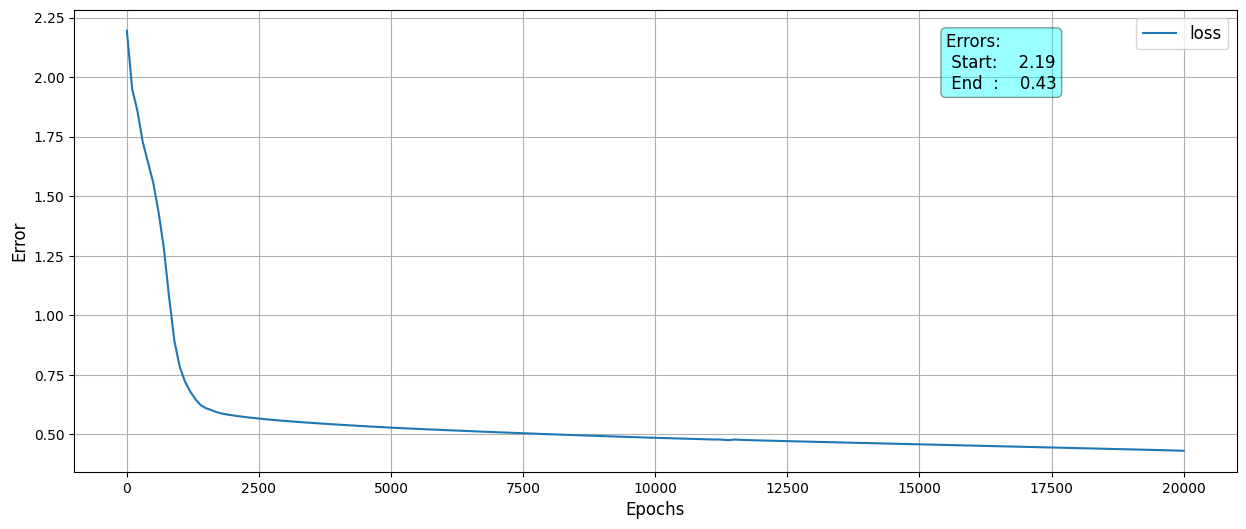

In [31]:
fig, ax = plt.subplots()# initiate figure and axis
loss_df.plot(x = 'epoch', y= 'loss', ax = ax)
txtstr = "Errors: \n Start: {:7.2f}\n End  : {:7.2f}".format(loss_df.iloc[0]['loss'],
                                                             loss_df.iloc[-1]['loss'])

props = dict (boxstyle = 'round', facecolor = 'cyan', alpha = 0.4)

ax.text(0.75, 0.95, txtstr,
        transform=ax.transAxes,
        fontsize = 12,
        verticalalignment = 'top',
        bbox = props)

ax.set_xlabel('Epochs')
ax.set_ylabel('Error')

ax.grid();

Train Predictions

In [32]:
y_pred = predict(model, X_train)

print(f'Accuracy: {accuracy_score (np.argmax(y_train, axis=1), y_pred):7.4f}')

Accuracy:  0.9183


In [36]:
# In cell ipython-input-32-2cbc7313dd44
y_train_pred = predict(model, X_train)

# In cell ipython-input-35-2cbc7313dd44
print(classification_report(np.argmax(y_train, axis=1), y_train_pred))

# In cell ipython-input-37-2cbc7313dd44
y_test_pred = predict(model, X_test)

# In the following cells for test evaluation
print(f'Accuracy: {accuracy_score (y_test.argmax(axis=1), y_test_pred):7.4f}')
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.96      0.94      0.95      4693
           2       0.86      0.94      0.90      5470
           3       0.93      0.79      0.85      2734

    accuracy                           0.92     14517
   macro avg       0.94      0.92      0.93     14517
weighted avg       0.92      0.92      0.92     14517

Accuracy:  0.8700
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.91      0.90      0.91      1173
           2       0.80      0.88      0.84      1368
           3       0.86      0.73      0.79       684

    accuracy                           0.87      3630
   macro avg       0.89      0.88      0.88      3630
weighted avg       0.87      0.87      0.87      3630



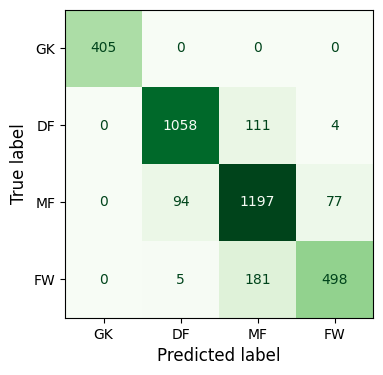

In [38]:
display_labels = ['GK','DF','MF','FW']

# Use y_test for the true labels to match the y_pred (which contains test set predictions)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Greens', colorbar=False)

Test Predictions

In [39]:
y_pred = predict(model, X_test)

print(f'Accuracy: {accuracy_score (y_test.argmax(axis=1), y_pred):7.4f}')

Accuracy:  0.8700


In [40]:
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.91      0.90      0.91      1173
           2       0.80      0.88      0.84      1368
           3       0.86      0.73      0.79       684

    accuracy                           0.87      3630
   macro avg       0.89      0.88      0.88      3630
weighted avg       0.87      0.87      0.87      3630

